# Neuron Collections

Our classes for LIF neurons and synapses currently represent *one* neuron or synapse. However, we usually want to represent **many** neurons and synapses. We could do this by creating many instances of the `Neuron` class but this would be inefficient. Instead, we can create a `NeuronCollection` class that can store many neurons and update them in parallel.

:::{dropdown} What does "in parallel" mean?

Suppose we have a list `L` and want to multiply each element by `1.2`. We could do this in a loop:

```python
L = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Update L by multiplying each element by 1.2
for i in range(len(L)): # i is the index of the element (0, 1, 2, ...)
    L[i] = L[i] * 1.2
```

This is called updating the list **sequentially**; we loop over the sequence and update each item in `L` one-by-one. We could instead do this **in parallell**, meaning that we will update every item **at the same time**:

```python
import numpy as np

L = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
L = L * 1.2 # Multiply each element by 1.2 in parallel
```
:::

If we use NumPy, we can update [our old code](./12%20-%20Improving%20Accuracy.ipynb) to represent groups of neurons:

In [20]:
import numpy as np

np.random.seed(0)

class LIFCollection:
    def __init__(self, n=1, dim=1, tau_rc=0.02, tau_ref=0.002, v_th=1, 
                 max_rates=[200, 400], intercept_range=[-1, 1], t_step=0.001, v_init = 0):
        self.n = n
        # Set neuron parameters
        self.dim = dim  # Dimensionality of the input
        self.tau_rc = tau_rc  # Membrane time constant
        self.tau_ref = tau_ref  # Refractory period
        self.v_th = np.ones(n) * v_th  # Threshold voltage for spiking
        self.t_step = t_step  # Time step for simulation
        
        # Initialize state variables
        self.voltage = np.ones(n) * v_init  # Initial voltage of neurons
        self.refractory_time = np.zeros(n)  # Time remaining in refractory period
        self.output = np.zeros(n)  # Output spikes

        # Generate random max rates and intercepts within the given range
        max_rates_tensor = np.random.uniform(max_rates[0], max_rates[1], n)
        intercepts_tensor = np.random.uniform(intercept_range[0], intercept_range[1], n)

        # Calculate gain and bias for each neuron
        self.gain = self.v_th * (1 - 1 / (1 - np.exp((self.tau_ref - 1/max_rates_tensor) / self.tau_rc))) / (intercepts_tensor - 1)
        self.bias = np.expand_dims(self.v_th - self.gain * intercepts_tensor, axis=1)
        
        # Initialize random encoders
        self.encoders = np.random.randn(n, self.dim)
        self.encoders /= np.linalg.norm(self.encoders, axis=1)[:, np.newaxis]

    def reset(self):
        # Reset the state variables to initial conditions
        self.voltage = np.zeros(self.n)
        self.refractory_time = np.zeros(self.n)
        self.output = np.zeros(self.n)

    def step(self, inputs):
        dt = self.t_step  # Time step

        # Update refractory time
        self.refractory_time -= dt
        delta_t = np.clip(dt - self.refractory_time, 0, dt) # ensure between 0 and dt

        # Calculate input current
        I = np.sum(self.bias + inputs * self.encoders * self.gain[:, np.newaxis], axis=1)

        # Update membrane potential
        self.voltage = I + (self.voltage - I) * np.exp(-delta_t / self.tau_rc)

        # Determine which neurons spike
        spike_mask = self.voltage > self.v_th
        self.output[:] = spike_mask / dt  # Record spikes in output

        # Calculate the time of the spike
        t_spike = self.tau_rc * np.log((self.voltage[spike_mask] - I[spike_mask]) / (self.v_th[spike_mask] - I[spike_mask])) + dt

        # Reset voltage of spiking neurons
        self.voltage[spike_mask] = 0

        # Set refractory time for spiking neurons
        self.refractory_time[spike_mask] = self.tau_ref + t_spike

        return self.output  # Return the output spikes

array([1000.,    0., 1000.,    0.,    0., 1000., 1000.,    0., 1000.,
          0.])

In [21]:
import matplotlib.pyplot as plt

t_step = 0.001
neurons = LIFCollection(n=10, dim=1, t_step=t_step)

def compute_response(neuron, inputs, T = 10):
    spike_count = np.zeros(len(neuron.output))
    for _ in np.arange(0, T, t_step):
        output = neuron.step(inputs)
        spike_count += output * t_step
    return spike_count / T

inputs = np.arange(-1, 1, 0.05)
responses = []
for i in inputs:
    response = compute_response(neurons, i)
    responses.append(response)

plt.plot(inputs, responses)
plt.show()

KeyboardInterrupt: 

We can do essentially the same thing with our synapses and create a `SynapseCollection` class to represent many synapses that get updated in parallel.

In [3]:
class SynapseCollection:
    def __init__(self, n=1, tau_s=0.05, t_step=0.001):
        self.n = n
        self.a = np.exp(-t_step / tau_s)  # Decay factor for synaptic current
        self.b = 1 - self.a  # Scale factor for input current

        self.voltage = np.zeros(n)  # Initial voltage of neurons
    
    def step(self, inputs):
        self.voltage = self.a * self.voltage + self.b * inputs

        return self.voltage

If we send in a signal (`np.sin`) and use [the decoders from before](./09%20-%20Collections%20of%20Neurons.ipynb), we can decode output signals from collections of neurons.

In [4]:
def getDecoders(neurons, minJ=-1, maxJ=1, stepSize=0.01):
    def analyticalRate(v_th, tau_ref, tau_rc, I):
        if I <= v_th: return 0
        else:         return 1 / (tau_ref - tau_rc * np.log(1 - v_th/I))
    

    inputs = np.arange(minJ, maxJ, stepSize)

    gain_matrix = np.tile(neurons.gain[:, np.newaxis], (1, len(inputs)))
    bias_matrix = np.tile(neurons.bias, (1, len(inputs)))
    encoders_matrix = np.tile(neurons.encoders, (1, len(inputs)))

    I = inputs * gain_matrix * encoders_matrix + bias_matrix

    tuningCurves = np.vectorize(analyticalRate)(neurons.v_th[-1], neurons.tau_ref, neurons.tau_rc, I)

    A = np.array(tuningCurves)

    value = np.expand_dims(inputs, axis=1)

    Gamma = A @ A.T + np.identity(len(neurons.output))
    GammaInv = np.linalg.inv(Gamma)
    Upsilon = A @ value

    Phi = GammaInv @ Upsilon

    return Phi

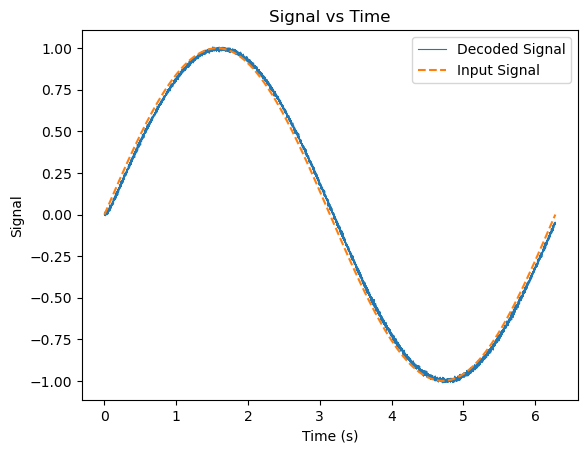

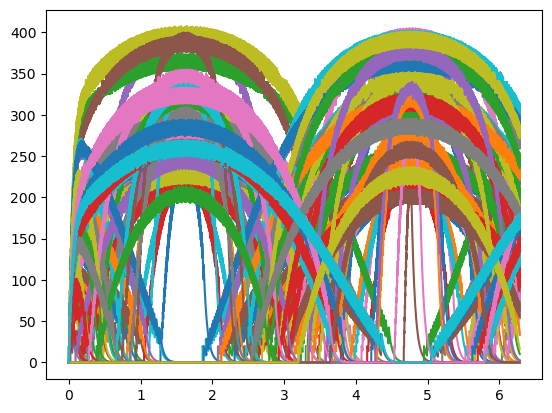

In [5]:
t_step = 0.001
n = 100
neurons = LIFCollection(n=n, t_step=t_step)
synapses = SynapseCollection(n=n, t_step=t_step)

def step(inputs):
    neuron_output = neurons.step(inputs)
    return synapses.step(neuron_output)

def signal(t):
    return np.sin(t)

T = 2*np.pi

t = np.arange(0, T, t_step)
inputs = signal(t)

outputs = []
for i in inputs:
    output = step(i)
    outputs.append(output)


Phi = getDecoders(neurons)

plt.figure()
plt.plot(t, outputs @ Phi, linewidth=0.8)
plt.plot(t, inputs, linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Signal vs Time')
plt.legend(['Decoded Signal', 'Input Signal'])
plt.show()

plt.title("Neuron Voltage vs Time")
plt.plot(t, outputs)
plt.show()

## Summary

- We can represent (and update) many neurons in parallel using NumPy.